# Predicción de accidentes cerebrovasculares por medio de algoritmos de machine learning

## Librerías que serán utilizadas

In [1]:
# Procesado y tratamiento de los datos
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceo del dataset
from imblearn.over_sampling import SMOTEN

# División del dataset
from sklearn.model_selection import train_test_split

# Búsqueda de los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Modelos utilizados 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métricas de evaluación
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Otros
import warnings 
warnings.filterwarnings('ignore')

In [6]:
# Lectura del dataset 
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
# Visualización inicial del conjunto de datos
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Análisis exploratorio de los datos

In [ ]:
# Visualizamos la informacion básica del conjunto de datos
# Indica el numero de filas del dataset
# Muestra el numero de datos No Nulos por columna (valores validos)
# Tipo de dato de cada columna
# Tamaño total del dataset
data.info()

In [ ]:
# Dimensiones del dataset
# Muestra la cantidad de datos y el número de columnas que posee el dataset
data.shape

In [ ]:
# Validación de datos duplicados
data.duplicated().sum()

In [ ]:
# Número de datos ausentes por variable
print(data.isnull().sum())

In [7]:
# Eliminación de datos que son irrelevantes y que podrian afectar el resultado.
df = data.drop(['id'], axis=1)

In [ ]:
# Visualización de la información estadística del conjunto de datos
# Para las variables numéricas
df.describe()

In [ ]:
# Visualización de la información estadística del conjunto de datos
# Para las variables cualitativas o categóricas 
df.select_dtypes(include=['object']).describe()

In [ ]:
# Validamos correlaciones
correlation = df.corr()
fig = plt.figure (figsize = (15,7))
ax = fig.add_subplot(111)
df.plot = sns.heatmap(correlation, cmap="YlGnBu", annot=True) 
plt.show()  


In [ ]:
# Verificamos cuales son las variables que poseen mas correlación con respecto a la variable de salida
df.corr()['stroke'].sort_values()

## Analisis de las variables númericas

In [ ]:
# Gráficas de distribución para cada variable numérica
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flat
# Seleccionamos el tipo de variable a gráficar
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
# Se elimina la variable de salida
columnas_numeric = columnas_numeric.drop('stroke')
# Recorremos cada columna seleccionada 
for i, colum in enumerate(columnas_numeric):
    # Gráficamos cada columna 
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [5]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

In [ ]:
# Función que calcula los valores del límite inferior y superior en las variables numericas
# Para poder identificar y analizar los posibles outliers que las varibles puedan contener
def calcula_limites(data,ft):
    # Cálculamos los valores de los cuartiles
    Q1 = data[ft].quantile(0.25)
    Q3 = data[ft].quantile(0.75)
    # Cálculamos el rango intercuartílico 
    IQR = Q3 - Q1
    # Cálculamos los valores de los bigotes inferior y superior
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    # Impimimos los valores cálculados
    print(f"El límite inferior es {lower_bound} y el límite superior {upper_bound}")
    # Retornamos los valores del límite inferior y superior
    return lower_bound, upper_bound

In [ ]:
# Gráfica de caja para la variable "age"
figura, ejes = plt.subplots( figsize= (8,6))
green_diamond = dict(markerfacecolor='y', marker='D')
sns.set_palette("colorblind")

sns.boxplot(data=df,
            x="stroke",
            y="age",
            hue="stroke",
            flierprops=green_diamond)
plt.grid(False)

plt.show()

In [ ]:
# Ejecutamos la funcion para validar los valores del limite inferior y superior en la variable "age"
# que refleja algunos outliers, que se pueden vizualizar en la grafica de caja anteriror
lower_bound, upper_bound = calcula_limites(df,'age')

In [ ]:
# Extraemos las filas, que contengan valores en la columna "age" que sobrepasen los valores de los límites cálculados
data_children = df[(df['age'] > upper_bound) | (df['age'] < lower_bound)]
# Vizualizamos los datos localizados 
data_children

In [8]:
# Extraemos las filas que contengan edades menores a 18 años 
data_children1 = df[(df['age'] < 18)]
# Vizualizamos los datos localizados 
data_children1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
5089,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5094,Male,13.00,0,0,No,children,Urban,82.38,24.3,Unknown,0
5095,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0
5098,Male,9.00,0,0,No,children,Urban,71.88,17.5,Unknown,0


In [9]:
# Visualización de la información estadística de los datos localizados
# Para las variables numéricas
data_children1.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,856.000000,856.000000,856.000000,856.000000,836.000000,856.000000
mean,8.560748,0.001168,0.001168,94.385981,21.392703,0.002336
std,5.386510,0.034179,0.034179,27.129487,6.278310,0.048309
min,0.080000,0.000000,0.000000,55.340000,10.300000,0.000000
25%,3.000000,0.000000,0.000000,76.120000,17.600000,0.000000
50%,8.000000,0.000000,0.000000,89.075000,19.900000,0.000000
75%,13.000000,0.000000,0.000000,109.040000,23.500000,0.000000
max,17.000000,1.000000,1.000000,233.710000,97.600000,1.000000


In [ ]:
# Visualización de la información estadística de los datos localizados
# Para las variables cualitativas o categóricas 
data_children1.select_dtypes(include=['object']).describe()

In [ ]:
# Recuento de cada categoría de datos para la variable "work_type"
data_children1.work_type.value_counts().sort_index()

In [ ]:
# Recuento de casos de ACV en los datos
data_children1[data_children1['stroke']==1]

In [10]:
# Reagrupación de la varibale smoking_status
dic_replace = {'Govt_job': "children",
               'Never_worked': "children",
               'Private': "children",
               'Self-employed': "children"}

In [11]:
data_children1['work_type'] = data_children1['work_type'].map(dic_replace).fillna(data_children1['work_type'])

In [12]:
# Se eliminaran las filas con valores menores a 18 años en la columna "age"
# Seleccionamos los datos a eliminar
data_apart=df[df['age']< 18].index
# Eliminamos los datos seleccionados
data_clean=df.drop(data_apart)
# Reseteamos el index de la filas
data_clean.reset_index(drop=True, inplace=True)
# Vizualizamos los cambios aplicados
data_clean  

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4249,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
4250,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
4251,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
4252,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [13]:
# Concatenamos el dataset sin la carateristica tranformada y el dataset de la caracteristica tranformada
data_clean1 = pd.concat([data_clean, data_children1],ignore_index=True)
# Visualizamos los cambios aplicados
data_clean1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5106,Male,13.00,0,0,No,children,Urban,82.38,24.3,Unknown,0
5107,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0
5108,Male,9.00,0,0,No,children,Urban,71.88,17.5,Unknown,0


In [ ]:
# Gráfica de caja para la variable "avg_glucose_level"
figura, ejes = plt.subplots(figsize= (8,8))
green_diamond = dict(markerfacecolor='y', marker='D')
sns.set_palette("colorblind")

sns.boxplot(data=data_clean1,
            x="stroke",
            y="avg_glucose_level",
            hue="stroke",
            flierprops=green_diamond)
plt.grid(False)

plt.show()

In [ ]:
# Ejecutamos la función para validar los valores del limite inferior y superior en la variable "avg_glucose_level"
# que refleja algunos outliers, que se pueden vizualizar en la grafica de caja anteriror
lower_bound, upper_bound = calcula_limites(data_clean1,'avg_glucose_level')

In [ ]:
# Extraemos las filas, que contengan valores en la columna "avg_glucose_level" que sobrepasen los valores de los límites cálculados
data_glucose = data_clean1[(data_clean1['avg_glucose_level'] > upper_bound ) | (data_clean1['avg_glucose_level'] < lower_bound)]
# Vizualizamos los datos localizados
data_glucose

In [ ]:
# Recuento de casos de ACV en los datos
data_glucose.stroke.value_counts().sort_index()

In [ ]:
# Visualización de la información estadística del conjunto de datos
# Para las variables numéricas
data_glucose.describe()

In [ ]:
# Visualización de la información estadística del conjunto de datos
# Variables cualitativas o categóricas 
data_glucose.select_dtypes(include=['object']).describe()

In [ ]:
# Gráfica de caja para la variable "bmi"
figura, ejes = plt.subplots(figsize= (8,8))
green_diamond = dict(markerfacecolor='y', marker='D')
sns.set_palette("colorblind")

sns.boxplot(data=data_clean1,
            x="stroke",
            y="bmi",
            hue="stroke",
            flierprops=green_diamond)
plt.grid(False)

plt.show()

In [ ]:
# Ejecutamos la función para validar los valores del limite inferior y superior en la variable "avg_glucose_level"
# que refleja algunos outliers, que se pueden vizualizar en la grafica de caja anteriror
lower_bound, upper_bound = calcula_limites(data_clean1,'bmi')

In [ ]:
# Extraemos las filas, que contengan valores en la columna "avg_glucose_level" que sobrepasen los valores de los límites cálculados
data_bmi = data_clean1[(data_clean1['bmi'] >  upper_bound ) | (data_clean1['bmi'] < lower_bound)]
# Vizualizamos los datos localizados
data_bmi

In [ ]:
# Recuento de casos de ACV en los datos
data_bmi.stroke.value_counts().sort_index()

In [ ]:
# Visualización de la información estadística del conjunto de datos
# Para las variables numéricas
data_bmi.describe()

In [ ]:
# Visualización de la información estadística del conjunto de datos
# Variables cualitativas o categóricas 
data_bmi.select_dtypes(include=['object']).describe()

Relleno de los valores faltantes en las variables numéricas, en este caso únicamente en la variable "bmi"

In [14]:
# Separamos la varible "bmi" del resto de datos
num_missing = data_clean1[['bmi']]
# Visualizamos los datos separados
num_missing

,bmi
0,36.6
1,NaN
2,32.5
3,34.4
4,24.0
...,...
5105,16.8
5106,24.3
5107,17.4
5108,17.5


In [15]:
# Definimos la estrategia a utilizar
imputer = SimpleImputer(strategy='median')
# Pasamos el dataset con los valores seleccionados
imputer.fit(num_missing)
# Rellenamos los valores nulos
num_relleno = imputer.transform(num_missing)

In [16]:
# Transformamos el resultado a un DataFrame de Pandas
num_filling = pd.DataFrame(num_relleno, columns=num_missing.columns)
# Visualizamos los cambios aplicados
num_filling

,bmi
0,36.6
1,28.1
2,32.5
3,34.4
4,24.0
...,...
5105,16.8
5106,24.3
5107,17.4
5108,17.5


In [17]:
# Pasamos las características transformadas al dataset original:
# Eliminamos la columna del dataset original 
data_clean2 = data_clean1.drop(['bmi'], axis=1)
# Visualizamos los cambios aplicados
data_clean2

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,never smoked,1
...,...,...,...,...,...,...,...,...,...,...
5105,Female,0.72,0,0,No,children,Rural,62.13,Unknown,0
5106,Male,13.00,0,0,No,children,Urban,82.38,Unknown,0
5107,Male,1.08,0,0,No,children,Rural,79.15,Unknown,0
5108,Male,9.00,0,0,No,children,Urban,71.88,Unknown,0


In [18]:
# Concatenamos el dataset sin la caraterística transformada y el dataset de la característica transformada
data_new1 = pd.concat([data_clean2,num_filling], axis=1,sort=True)
# Visualizamos los cambios aplicados
data_new1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
0,Male,67.00,0,1,Yes,Private,Urban,228.69,formerly smoked,1,36.6
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,28.1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,never smoked,1,32.5
3,Female,49.00,0,0,Yes,Private,Urban,171.23,smokes,1,34.4
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,0.72,0,0,No,children,Rural,62.13,Unknown,0,16.8
5106,Male,13.00,0,0,No,children,Urban,82.38,Unknown,0,24.3
5107,Male,1.08,0,0,No,children,Rural,79.15,Unknown,0,17.4
5108,Male,9.00,0,0,No,children,Urban,71.88,Unknown,0,17.5


## Análisis de las variables categóricas 

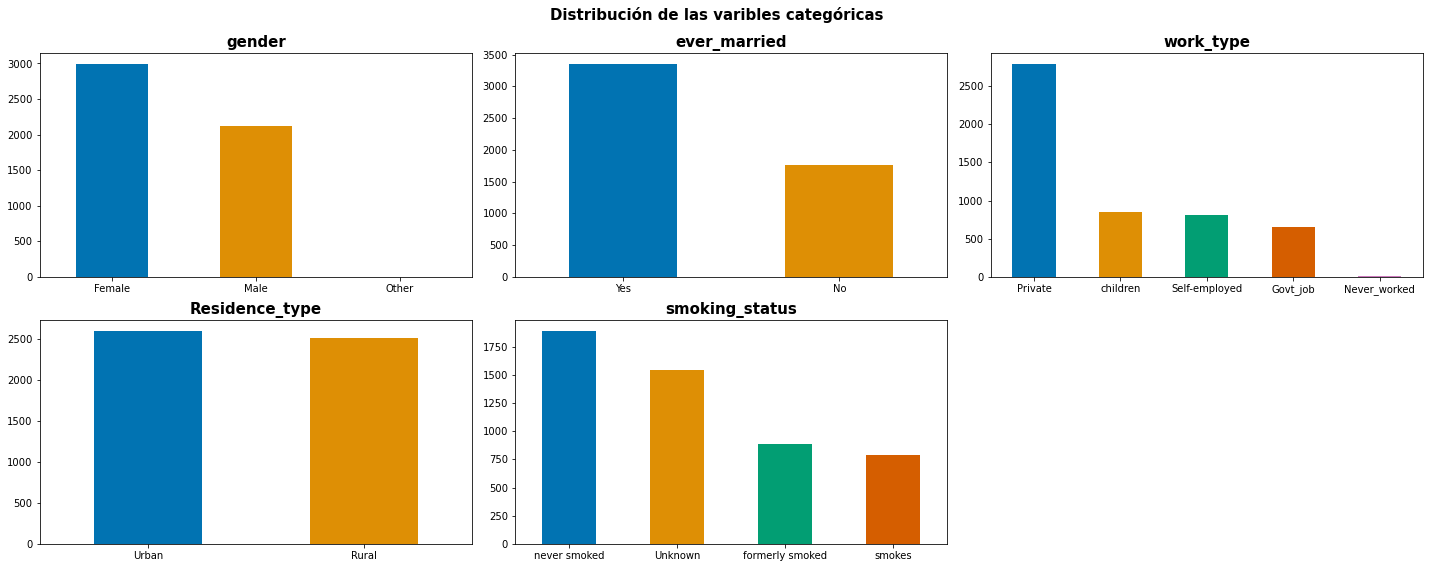

In [20]:
# Gráficas de distribución para cada variable categórica: nominales y ordinales
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
axes = axes.flat
# Seleccionamos el tipo de variable a gráficar
columnas_object = data_new1.select_dtypes(include=['object']).columns
# Recorremos cada columna seleccionada
for i, colum in enumerate(columnas_object):
    # Gráficamos cada columna 
    data_new1[colum].value_counts().plot.bar(ax = axes[i], color=sns.color_palette("colorblind"),rot=0)
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [5]:
   fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de las varibles categóricas',
             fontsize = 15, fontweight = "bold");

In [ ]:
# Gráfica de pastel de la variable "gender", para validar el porcentaje de cada categoría que posee dicha columna.
# Seleccionamos la variable a gráficar
gender = data_new1['gender'].value_counts()
names = 'Masculino', 'Femenino', 'Otro'
fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=gender, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("colorblind"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Genero"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
# Separamos las filas que contengan "Other" en la columna "gender" para poder analizarlas.
data_count1 = data_new1[(data_new1['gender']=='Other')]
# Visualizamos el tamaño del dataset generado con los valores seleccionados
data_count1.shape

In [ ]:
# Recuento de valores para la variable de salida
data_count1.groupby("stroke").size()

Se eliminaran las filas con valores "Other" en la columna "gender", ya que contienen una cantidad muy baja de datos, 
los cuales desbalancean la distribución de los valores de la variable.

In [21]:
# Seleccionamos los datos a eliminar 
data_apart2=data_new1[data_new1["gender"]=='Other'].index
# Eliminados los datos seleccionados 
data_clean3=data_new1.drop(data_apart2)
# Reseteamos el index de la filas
data_clean3.reset_index(drop=True, inplace=True)
# Visualizamos los cambios aplicados 
data_clean3

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
0,Male,67.00,0,1,Yes,Private,Urban,228.69,formerly smoked,1,36.6
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,28.1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,never smoked,1,32.5
3,Female,49.00,0,0,Yes,Private,Urban,171.23,smokes,1,34.4
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,0.72,0,0,No,children,Rural,62.13,Unknown,0,16.8
5105,Male,13.00,0,0,No,children,Urban,82.38,Unknown,0,24.3
5106,Male,1.08,0,0,No,children,Rural,79.15,Unknown,0,17.4
5107,Male,9.00,0,0,No,children,Urban,71.88,Unknown,0,17.5


In [ ]:
# Gráfica de pastel de la variable "work_type", para validar el porcentaje de cada categoría que posee dicha columna.
# Seleccionamos la variable a gráficar
work_type = data_clean3['work_type'].value_counts()
names = 'Privado', 'Cuenta Propia', 'Gobierno', 'Nunca ha Trabajado'
fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=work_type, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("colorblind"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Tipo Trabajo"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [22]:
# Separamos las filas que contengan "Never_worked" en la columna "work_type" para poder analizarlas.
data_count2 = data_clean3[(data_clean3["work_type"]=='Never_worked')]
# Visualizamos el tamaño del dataset generado con los valores seleccionados
data_count2.shape

(5, 11)

In [ ]:
# Recuento de valores para la variable de salida
data_count2.groupby("stroke").size()

Se eliminaran las filas con valores "Never_worked" en la columna "work_type", ya que contienen una cantidad muy baja de datos, 
los cuales desbalancean la distribución de los valores de la variable.

In [23]:
# Seleccionamos los datos a eliminar 
data_apart3=data_clean3[data_clean3["work_type"]=='Never_worked'].index
# Eliminados los datos seleccionados 
data_clean4=data_clean3.drop(data_apart3)
# Reseteamos el index de la filas
data_clean4.reset_index(drop=True, inplace=True)
# Visualizamos los cambios aplicados 
data_clean4

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
0,Male,67.00,0,1,Yes,Private,Urban,228.69,formerly smoked,1,36.6
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,28.1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,never smoked,1,32.5
3,Female,49.00,0,0,Yes,Private,Urban,171.23,smokes,1,34.4
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5099,Female,0.72,0,0,No,children,Rural,62.13,Unknown,0,16.8
5100,Male,13.00,0,0,No,children,Urban,82.38,Unknown,0,24.3
5101,Male,1.08,0,0,No,children,Rural,79.15,Unknown,0,17.4
5102,Male,9.00,0,0,No,children,Urban,71.88,Unknown,0,17.5


In [ ]:
# Gráfica de pastel de la variable "smoking_status", para validar el porcentaje de cada categoría que posee dicha columna.
# Seleccionamos la variable a gráficar
smoking_status = data_clean4['smoking_status'].value_counts()
names = 'Nunca ha fumado', 'No se sabe', 'Antes fumaba', 'Fumadores'
fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=smoking_status, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("colorblind"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Estado Fumador"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
# Separamos las filas que contengan "Unknown" en la columna "smoking_status" para poder analizarlas.
data_count3 = data_clean4[(data_clean4["smoking_status"]=='Unknown')]
# Visualizamos el tamaño del dataset generado con los valores seleccionados
data_count3.shape

In [ ]:
# Recuento de valores para la variable de salida
data_count3.groupby("stroke").size()

In [24]:
# Reemplazamos los valores "Unknown" en la columna "smoking_status" con valores vacios. 
data_clean4.loc[data_clean4['smoking_status'] == 'Unknown', 'smoking_status'] = np.nan
# Visualizamos los cambios aplicados 
data_clean4

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
0,Male,67.00,0,1,Yes,Private,Urban,228.69,formerly smoked,1,36.6
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,28.1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,never smoked,1,32.5
3,Female,49.00,0,0,Yes,Private,Urban,171.23,smokes,1,34.4
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5099,Female,0.72,0,0,No,children,Rural,62.13,NaN,0,16.8
5100,Male,13.00,0,0,No,children,Urban,82.38,NaN,0,24.3
5101,Male,1.08,0,0,No,children,Rural,79.15,NaN,0,17.4
5102,Male,9.00,0,0,No,children,Urban,71.88,NaN,0,17.5


Relleno de los valores faltantes en las variables categóricas, en este caso únicamente en la variable "smoking_status"

In [25]:
# Separamos la varible "smoking_status" del resto de datos
cat_missing = data_clean4[['smoking_status']]
# Visualizamos los datos separados
cat_missing 

,smoking_status
0,formerly smoked
1,never smoked
2,never smoked
3,smokes
4,never smoked
...,...
5099,NaN
5100,NaN
5101,NaN
5102,NaN


In [26]:
# Definimos la estrategia a utilizar
imputer = SimpleImputer(strategy='most_frequent')
# Pasamos el dataset con los valores seleccionados
imputer.fit(cat_missing)
# Rellenamos los valores nulos
cat_relleno = imputer.transform(cat_missing)

In [27]:
# Transformamos el resultado a un DataFrame de Pandas
data_filling = pd.DataFrame(cat_relleno, columns=cat_missing.columns)
# Visualizamos los cambios aplicados
data_filling

,smoking_status
0,formerly smoked
1,never smoked
2,never smoked
3,smokes
4,never smoked
...,...
5099,never smoked
5100,never smoked
5101,never smoked
5102,never smoked


In [28]:
# Recuento de cada categoría después de la transformación realizada
data_filling.smoking_status.value_counts().sort_index()

formerly smoked     884
never smoked       3431
smokes              789
Name: smoking_status, dtype: int64

In [29]:
# Pasar las características transformadas al dataset original
# Eliminamos la columna del dataset original 
data_clean5 = data_clean4.drop(['smoking_status'], axis=1)
# Visualizamos los cambios aplicados
data_clean5

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,stroke,bmi
0,Male,67.00,0,1,Yes,Private,Urban,228.69,1,36.6
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,1,28.1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,1,32.5
3,Female,49.00,0,0,Yes,Private,Urban,171.23,1,34.4
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,1,24.0
...,...,...,...,...,...,...,...,...,...,...
5099,Female,0.72,0,0,No,children,Rural,62.13,0,16.8
5100,Male,13.00,0,0,No,children,Urban,82.38,0,24.3
5101,Male,1.08,0,0,No,children,Rural,79.15,0,17.4
5102,Male,9.00,0,0,No,children,Urban,71.88,0,17.5


In [30]:
# Concatenamos el dataset sin la caraterística transformada y el dataset de la característica transformada
data_new3 = pd.concat([data_clean5,data_filling], axis=1,sort=True)
# Visualizamos los cambios aplicados
data_new3

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,stroke,bmi,smoking_status
0,Male,67.00,0,1,Yes,Private,Urban,228.69,1,36.6,formerly smoked
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,1,28.1,never smoked
2,Male,80.00,0,1,Yes,Private,Rural,105.92,1,32.5,never smoked
3,Female,49.00,0,0,Yes,Private,Urban,171.23,1,34.4,smokes
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,1,24.0,never smoked
...,...,...,...,...,...,...,...,...,...,...,...
5099,Female,0.72,0,0,No,children,Rural,62.13,0,16.8,never smoked
5100,Male,13.00,0,0,No,children,Urban,82.38,0,24.3,never smoked
5101,Male,1.08,0,0,No,children,Rural,79.15,0,17.4,never smoked
5102,Male,9.00,0,0,No,children,Urban,71.88,0,17.5,never smoked


In [31]:
# Separamos en un dataset los casos de "accidentes cerebrovasculares" en mujeres
data_women = data_new3[(data_new3['gender']=='Female') & (data_new3['stroke'] == 1)]
data_women

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,stroke,bmi,smoking_status
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,1,28.1,never smoked
3,Female,49.00,0,0,Yes,Private,Urban,171.23,1,34.4,smokes
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,1,24.0,never smoked
7,Female,69.00,0,0,No,Private,Urban,94.39,1,22.8,never smoked
8,Female,59.00,0,0,Yes,Private,Rural,76.15,1,28.1,never smoked
...,...,...,...,...,...,...,...,...,...,...,...
242,Female,68.00,1,1,Yes,Private,Urban,247.51,1,40.5,formerly smoked
244,Female,75.00,0,0,Yes,Self-employed,Rural,78.80,1,29.3,formerly smoked
246,Female,78.00,0,0,Yes,Private,Rural,78.81,1,19.6,never smoked
4248,Female,1.32,0,0,No,children,Urban,70.37,1,28.1,never smoked


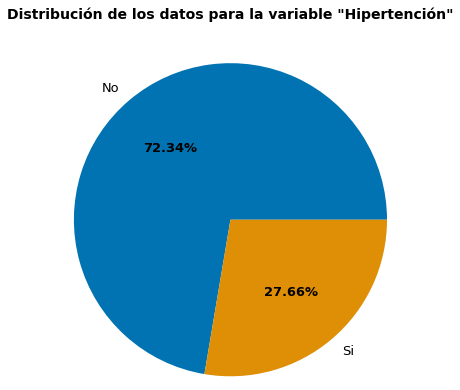

In [32]:
hypertension = data_women['hypertension'].value_counts()
names = 'No', 'Si'
fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=hypertension, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("colorblind"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Hipertención"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

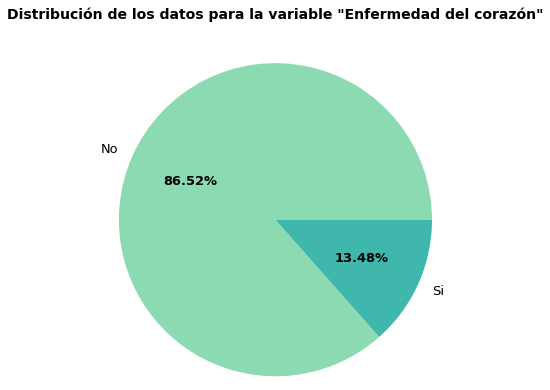

In [33]:
heart_disease = data_women['heart_disease'].value_counts()
names = 'No', 'Si'

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=heart_disease, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Enfermedad del corazón"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

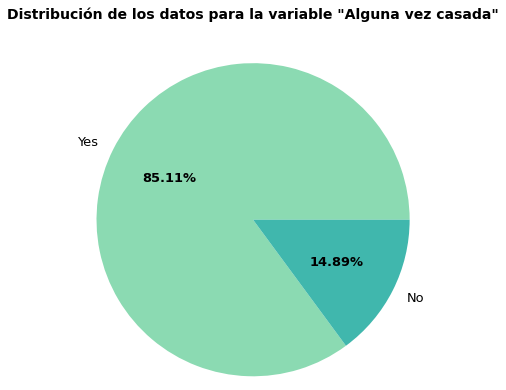

In [34]:
#Creación de una gráfica para representar el porcentaje de la variable ever_married
ever_married = data_women['ever_married'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=ever_married, labels=ever_married.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Alguna vez casada"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

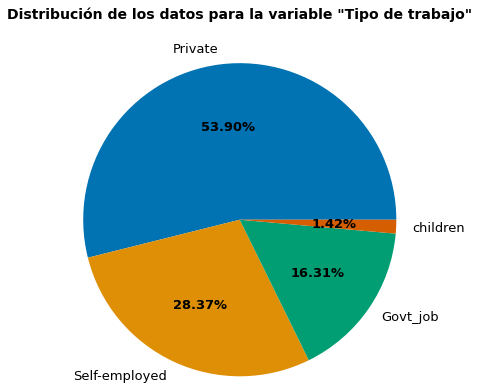

In [35]:
work_type = data_women['work_type'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=work_type, labels=work_type.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("colorblind"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Tipo de trabajo"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

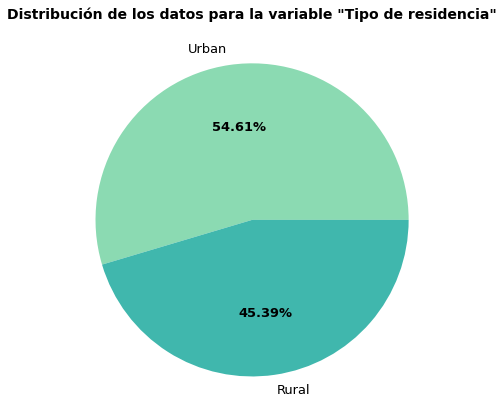

In [36]:
residence_type = data_women['Residence_type'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=residence_type, labels=residence_type.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Tipo de residencia"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

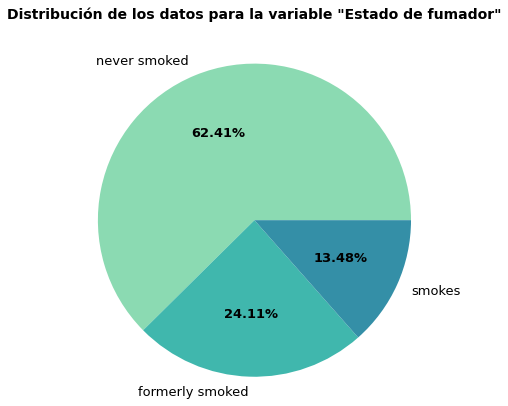

In [37]:
smoking_status = data_women['smoking_status'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=smoking_status, labels=smoking_status.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Estado de fumador"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
data_women.age_cat.value_counts().sort_index()

In [ ]:
age_cat = data_women['age_cat'].value_counts()
names = 'Anciano', 'Adulto medio', 'Adulto'
explodes = (0, 0, 0)

fig, ax = plt.subplots(figsize=(9, 10), subplot_kw=dict(aspect="equal"))
_, _, autotexts = ax.pie(age_cat, wedgeprops=dict(width=0.5), labels=names, autopct="%.2f%%", 
                         explode=explodes, shadow=True, startangle=5, textprops=dict(fontsize=12))

ax.set_title('Distribución de los datos para la variable "Edad"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

plt.show()

In [ ]:
age_cat = data_women['age_cat'].value_counts()
names = 'Anciano', 'Adulto medio', 'Adulto'
explodes = (0, 0, 0.4)
fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=age_cat, labels=names, autopct="%.2f%%", startangle=9, radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=explodes, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Estado de fumador"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
# Separamos en un dataset los casos de "accidentes cerebrovasculares" en hombres
data_men = data_new3[(data_new3['gender']=='Male') & (data_new3['stroke'] == 1)]
data_men

In [ ]:
hypertension = data_men['hypertension'].value_counts()
names = 'No', 'Si'
fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=hypertension, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Hipertención"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
heart_disease = data_men['heart_disease'].value_counts()
names = 'No', 'Si'

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=heart_disease, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Enfermedad del corazón"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
#Creación de una gráfica para representar el porcentaje de la variable ever_married
ever_married = data_men['ever_married'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=ever_married, labels=ever_married.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Alguna vez casada"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
work_type = data_men['work_type'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=work_type, labels=work_type.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Tipo de trabajo"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
residence_type = data_men['Residence_type'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=residence_type, labels=residence_type.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Tipo de residencia"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [ ]:
smoking_status = data_men['smoking_status'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=smoking_status, labels=smoking_status.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("mako_r"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Distribución de los datos para la variable "Estado de fumador"', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

In [38]:
# Del conjunto de datos general separamos la variable de salida del resto de datos
X_df = data_new3.drop("stroke", axis=1)
y_df = data_new3["stroke"].copy()

In [39]:
# Validamos la cantidad de casos de personas que han tenido un accidentes cerebrovascular y los casos de personas que no han tenido un accidentes cerebrovascular.
# Con esto podemos verificar si nuestro dataset esta desbalanceado y necesita que apliquemos alguna técnica de balanceo de datos. 
no = y_df.sum()
si = y_df.shape[0]- no
print('Personas que no tuvieron un ACV:',si,'Personas que si tuvieron un ACV:', no)

Personas que no tuvieron un ACV: 4855 Personas que si tuvieron un ACV: 249


In [40]:
# https://imbalanced-learn.org/dev/over_sampling.html
# Inicializamos el método de sobremuestreo
sampler = SMOTEN(random_state=0)
# Le pasamos el dataset
X_smoten, y_smoten = sampler.fit_resample(X_df, y_df)
# Hacemos un nuevo recuento para validar la cantidad de datos por cada caso
no_smoten = y_smoten.sum()
si_smoten = y_smoten.shape[0]- no_smoten
print('Personas que no tuvieron un ACV:', si_smoten ,'Personas que si tuvieron un ACV:', no_smoten)
# Visualizamos el dataset equilibrado para ambos casos 
X_smoten

Personas que no tuvieron un ACV: 4855 Personas que si tuvieron un ACV: 4855


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
...,...,...,...,...,...,...,...,...,...,...
9705,Male,60.0,0,1,Yes,Private,Urban,74.10,26.1,never smoked
9706,Female,79.0,0,0,Yes,Private,Rural,70.30,20.3,never smoked
9707,Female,58.0,0,0,Yes,Private,Rural,59.86,28.0,formerly smoked
9708,Male,57.0,0,1,Yes,Private,Urban,109.78,28.1,never smoked


In [41]:
# Separamos las columnas numéricas para escalarlas
colum_scal = X_smoten[["age", "avg_glucose_level", "bmi"]]
colum_scal

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,28.1
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0
...,...,...,...
9705,60.0,74.10,26.1
9706,79.0,70.30,20.3
9707,58.0,59.86,28.0
9708,57.0,109.78,28.1


In [42]:
#Escalado de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(colum_scal)

In [43]:
# Transformación a un DataFrame de Pandas
X_scaled = pd.DataFrame(X_scaled, columns=colum_scal.columns, index=colum_scal.index)
#Visualización de los cambios
X_scaled

,age,avg_glucose_level,bmi
0,0.643354,3.573636,1.455744
1,0.368773,2.884361,0.105150
2,1.238279,0.377929,0.804281
3,-0.180389,2.077951,1.106178
4,1.192515,2.153177,-0.546314
...,...,...,...
9705,0.323009,-0.450346,-0.212637
9706,1.192515,-0.549261,-1.134220
9707,0.231482,-0.821014,0.089260
9708,0.185719,0.478405,0.105150


In [44]:
# Pasar las características transformadas al dataset original
data_clean5 = X_smoten.drop(['age',"avg_glucose_level","bmi"], axis=1)
data_clean5

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
0,Male,0,1,Yes,Private,Urban,formerly smoked
1,Female,0,0,Yes,Self-employed,Rural,never smoked
2,Male,0,1,Yes,Private,Rural,never smoked
3,Female,0,0,Yes,Private,Urban,smokes
4,Female,1,0,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...,...,...
9705,Male,0,1,Yes,Private,Urban,never smoked
9706,Female,0,0,Yes,Private,Rural,never smoked
9707,Female,0,0,Yes,Private,Rural,formerly smoked
9708,Male,0,1,Yes,Private,Urban,never smoked


In [45]:
data_clean6 = pd.concat([data_clean5, X_scaled], axis=1,sort=True)
data_clean6 

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,age,avg_glucose_level,bmi
0,Male,0,1,Yes,Private,Urban,formerly smoked,0.643354,3.573636,1.455744
1,Female,0,0,Yes,Self-employed,Rural,never smoked,0.368773,2.884361,0.105150
2,Male,0,1,Yes,Private,Rural,never smoked,1.238279,0.377929,0.804281
3,Female,0,0,Yes,Private,Urban,smokes,-0.180389,2.077951,1.106178
4,Female,1,0,Yes,Self-employed,Rural,never smoked,1.192515,2.153177,-0.546314
...,...,...,...,...,...,...,...,...,...,...
9705,Male,0,1,Yes,Private,Urban,never smoked,0.323009,-0.450346,-0.212637
9706,Female,0,0,Yes,Private,Rural,never smoked,1.192515,-0.549261,-1.134220
9707,Female,0,0,Yes,Private,Rural,formerly smoked,0.231482,-0.821014,0.089260
9708,Male,0,1,Yes,Private,Urban,never smoked,0.185719,0.478405,0.105150


In [46]:
data_new4= pd.concat([data_clean6,y_smoten], axis=1,sort=True)
data_new4

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,age,avg_glucose_level,bmi,stroke
0,Male,0,1,Yes,Private,Urban,formerly smoked,0.643354,3.573636,1.455744,1
1,Female,0,0,Yes,Self-employed,Rural,never smoked,0.368773,2.884361,0.105150,1
2,Male,0,1,Yes,Private,Rural,never smoked,1.238279,0.377929,0.804281,1
3,Female,0,0,Yes,Private,Urban,smokes,-0.180389,2.077951,1.106178,1
4,Female,1,0,Yes,Self-employed,Rural,never smoked,1.192515,2.153177,-0.546314,1
...,...,...,...,...,...,...,...,...,...,...,...
9705,Male,0,1,Yes,Private,Urban,never smoked,0.323009,-0.450346,-0.212637,1
9706,Female,0,0,Yes,Private,Rural,never smoked,1.192515,-0.549261,-1.134220,1
9707,Female,0,0,Yes,Private,Rural,formerly smoked,0.231482,-0.821014,0.089260,1
9708,Male,0,1,Yes,Private,Urban,never smoked,0.185719,0.478405,0.105150,1


In [47]:
# Transformación de las columnas categóricas nominales a numéricas
# Seleccionamos las columnas que deben ser transformadas
data_clean7 = pd.get_dummies(data_new4, columns=['gender','ever_married','work_type','Residence_type','smoking_status'],drop_first = True)
# Visualizamos los cambios aplicados
data_clean7

,hypertension,heart_disease,age,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
0,0,1,0.643354,3.573636,1.455744,1,1,1,1,0,0,1,0,0
1,0,0,0.368773,2.884361,0.105150,1,0,1,0,1,0,0,1,0
2,0,1,1.238279,0.377929,0.804281,1,1,1,1,0,0,0,1,0
3,0,0,-0.180389,2.077951,1.106178,1,0,1,1,0,0,1,0,1
4,1,0,1.192515,2.153177,-0.546314,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9705,0,1,0.323009,-0.450346,-0.212637,1,1,1,1,0,0,1,1,0
9706,0,0,1.192515,-0.549261,-1.134220,1,0,1,1,0,0,0,1,0
9707,0,0,0.231482,-0.821014,0.089260,1,0,1,1,0,0,0,0,0
9708,0,1,0.185719,0.478405,0.105150,1,1,1,1,0,0,1,1,0


## División del conjunto de datos

In [48]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [49]:
# Division del conjunto de datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(data_clean7, stratify='stroke')

In [50]:
#Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 5826
Longitud del Validation Set: 1942
Longitud del Test Set: 1942


In [51]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("stroke", axis=1)
y_train = train_set["stroke"].copy()

In [52]:
# Conjunto de datos de pruebas
X_val = val_set.drop("stroke", axis=1)
y_val = val_set["stroke"].copy()

In [53]:
# Conjunto de datos de test
X_test = test_set.drop("stroke", axis=1)
y_test = test_set["stroke"].copy()

## Selección de los mejores modelos

In [54]:
# Pruebas de con diferentes modelos 
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['Ada Boost', AdaBoostClassifier()])

# Evaluación de los diferentes modelos
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kFold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()*100.0:,.2f}% ({cv_results.std()*100.0:,.2f}%)")

Logistic Regreesion: 82.56% (2.01%)
SVM: 88.48% (1.63%)
KNeighbors: 93.15% (1.12%)
GaussianNB: 74.03% (1.30%)
BernoulliNB: 78.61% (1.40%)
Decision Tree: 94.20% (0.91%)
Random Forest: 96.57% (0.66%)
Ada Boost: 88.59% (1.53%)


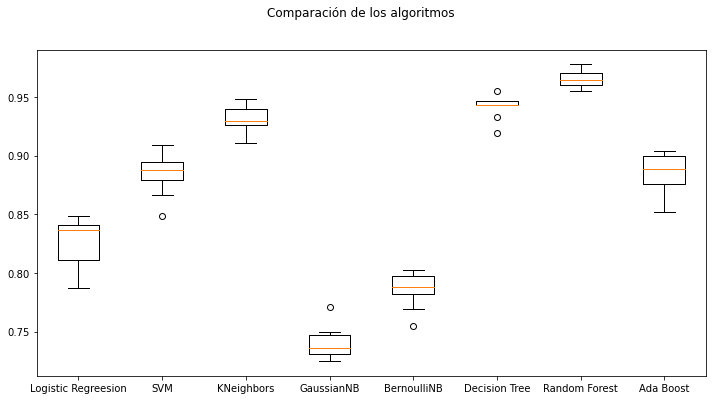

In [55]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados 
fig = plt.figure(figsize =(12,6))
fig.suptitle('Comparación de los algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hiperparametrización de los mejores modelos

In [56]:
# Búsqueda de los mejores parámetros para "K-Neighbors"
parameters1 = {"n_neighbors" : [1,3,5],
              "weights": ["uniform", "distance", None],
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
              }

model_KNN = KNeighborsClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid = GridSearchCV(estimator=model_KNN, param_grid=parameters1, cv=kFold, return_train_score=True)
grid_result1= grid.fit(X_train, y_train)

# mejores parámetros
grid_result1.best_params_

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}

In [57]:
# Búsqueda de los mejores parámetros para "Árboles de decisión"
parameters2 = {"max_depth": [1, 2, 3, None],
              "splitter": ["best", "random"],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_DTC = DecisionTreeClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid = GridSearchCV(estimator=model_DTC, param_grid=parameters2, cv=kFold, return_train_score=True)
grid_result2= grid.fit(X_train, y_train)

# mejores parámetros
grid_result2.best_params_

{'criterion': 'log_loss',
 'max_depth': None,
 'max_features': 3,
 'splitter': 'best'}

In [58]:
# Búsqueda de los mejores parámetros para "Bosques aleatorios"
parameters3 = {"max_depth": [1, 2, 3, None],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_RFC = RandomForestClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid = GridSearchCV(estimator=model_RFC, param_grid=parameters3, cv=kFold, return_train_score=True)
grid_result3= grid.fit(X_train, y_train)

# mejores parámetros
grid_result3.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt'}

## Evaluación del mejor modelo

In [59]:
# Comparación de modelos con los resultados de la búsqueda de los mejores parámetros 
models_hiper = []
models_hiper.append(['KNeighbors', KNeighborsClassifier(**grid_result1.best_params_)])
models_hiper.append(['Decision Tree', DecisionTreeClassifier(**grid_result2.best_params_)])
models_hiper.append(['Random Forest', RandomForestClassifier(**grid_result3.best_params_)])

# Evaluación de los diferentes modelos
results2 = []
names2 = []
scoring2 = 'accuracy'
for name, model in models_hiper:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results2 = cross_val_score(model, X_train, y_train, cv=kFold, scoring=scoring2)
    results2.append(cv_results2)
    names2.append(name)
    print(f"{name}: {cv_results2.mean()*100.0:,.2f}% ({cv_results2.std()*100.0:,.2f}%)")

KNeighbors: 94.11% (0.87%)
Decision Tree: 94.25% (0.80%)
Random Forest: 96.67% (0.50%)


In [60]:
# Entrenamiento y prueba con el mejor modelo 
# Inicializamos el modelo 
mejor_modelo = RandomForestClassifier(**grid_result3.best_params_)
# Le pasamos los datos de entrenamiento 
mejor_modelo.fit(X_train,y_train)

# Realizamos una nueva predición con los datos de prueba
y_pred = mejor_modelo.predict(X_val)

# Evaluamos el rendimiento del modelo con los datos de prueba 
accuracy_score(y_val, y_pred)

0.9778578784757982

In [61]:
# Realizamos una nueva predición con los datos de test
y_pred2 = mejor_modelo.predict(X_test)

# Evaluacion el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred2)

0.9757981462409887

## Reducción de características

In [64]:
# Selección de las características más importantes
feature_importances = {name: score for name, score in zip(list(X_train), mejor_modelo.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(3)

avg_glucose_level    0.276405
age                  0.252719
bmi                  0.226015
dtype: float64

In [65]:
# Extraemos las 3 características con mas relevancia para el algoritmo
columns = list(feature_importances_sorted.head(3).index)
columns

['avg_glucose_level', 'age', 'bmi']

In [66]:
# Aplicamos la reducción de características al dataset de entrenamiento y pruebas
X_train_reduced = X_train[columns].copy()
X_val_reduced = X_val[columns].copy()
X_test_reduced = X_test[columns].copy()
X_train_reduced.head(3)

,avg_glucose_level,age,bmi
9668,-0.418590,0.185719,0.105150
4982,0.073898,-1.736347,0.438826
469,-0.220501,-0.088862,0.359379


In [67]:
# Probamos el modelo nuevamente con el dataset reducido 
# Inicializamos el modelo 
mejor_modelo2 = RandomForestClassifier(**grid_result3.best_params_)
# Le pasamos los datos de entrenamiento 
mejor_modelo2.fit(X_train_reduced,y_train)

# Realizamos una nueva predición con los datos de prueba
y_pred3 = mejor_modelo2.predict(X_val_reduced)

# Evaluamos el rendimiento del modelo con los datos de prueba 
accuracy_score(y_val, y_pred3)

0.972193614830072

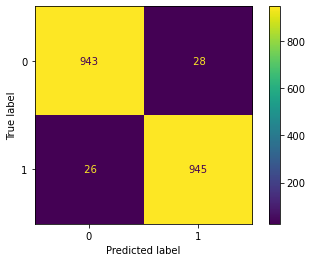

In [68]:
# Resultados de la matriz de confusión con los datos de prueba 
plot_confusion_matrix(mejor_modelo2, X_val_reduced, y_val, values_format='3g')

In [74]:
# Reporte de los resultados que se obtuvieron con los datos de prueba 
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       971
           1       0.97      0.97      0.97       971

    accuracy                           0.97      1942
   macro avg       0.97      0.97      0.97      1942
weighted avg       0.97      0.97      0.97      1942



In [70]:
# Realizamos una nueva predición con los datos de test
y_pred4 = mejor_modelo2.predict(X_test_reduced)

# Evaluamos el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred4)

0.972193614830072

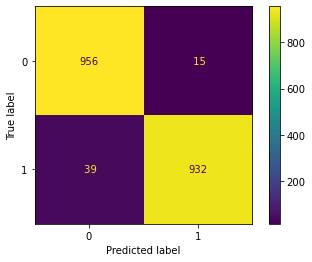

In [71]:
# Resultados de la matriz de confusión con los datos de test
plot_confusion_matrix(mejor_modelo2, X_test_reduced, y_test, values_format='3g')

In [73]:
# Reporte de los resultados que se obtuvieron con los datos de test
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       971
           1       0.98      0.96      0.97       971

    accuracy                           0.97      1942
   macro avg       0.97      0.97      0.97      1942
weighted avg       0.97      0.97      0.97      1942

